# Estimación de parámetros

In [3]:
import numpy as np
from matplotlib import pyplot as plt

## Procesos de reversión a la media con tendencia a largo plazo.

$$dX_t = \alpha(\mu(t) - X_t)dt + \sigma X_t^\gamma dB_t \qquad t\in[0,T] \qquad X_0 = x$$

* $\alpha>0$ es la tasa de reversión.
* $\mu(t)$ es una función determinista, el nivel medio de reversión.
* $\sigma > 0$ está asociado con la volatilidad.
* $\gamma \in [0, 3_/2]$ determina la sensibilidad de la varianza.

In [4]:
X0 = 2
alpha = 37
sigma = 0.7
gamma = 1
a = 1.5
b = 1
P = 1
beta = 2*np.pi/P
N = 250
dt = 1/250

#### Función de tendencia

In [5]:
def mu(t):
    return a + b*np.sin((2*np.pi*t)/P)

### Función media de $X_t$
Para $\mu(t) = a + b\sin(2\pi t/P)$

In [6]:
m0 = mu(0)
def m(t):
    c = a + (m0 - a + (a*beta*b)/(a**2* + beta**2))*np.exp(-alpha*t)
    d = ((a*b)/(a**2 + beta**2))*(alpha*np.sin(beta*t) - beta*np.cos(beta*t))
    return c + d

In [7]:
mu1 = np.zeros(N)
m1 = np.zeros(N)
for j in range(N):
    mu1[j] = mu(j*dt)
    m1[j] = m(j*dt)

In [8]:
X = np.zeros(N)
X[0] = X0
for j in range(1,N):
    X[j] = X[j-1] + alpha*(mu1[j] - X[j-1])*dt + sigma*X[j-1]**gamma*np.sqrt(dt)*np.random.normal()    

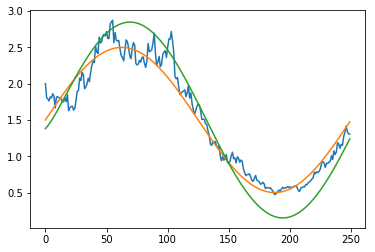

In [9]:
plt.plot(X)
plt.plot(mu1)
plt.plot(m1)
plt.show()

## Parámetros a estimar
$\theta = [\alpha, \sigma, \gamma]$

$$\mu(t) = m(t) + \frac{\dot{m}(t)}{\alpha}$$

_Derivada numérica_

In [68]:
def numDer(mi):
    mid = [(2*mi[i+1] - 3*mi[i] + mi[i-1])/dt for i in range(1,N-1)]
    mid.insert(0, (mi[1] - mi[0])/dt)
    mid.append((mi[-1] - mi[-2])/dt)
    return mid

_Estimación de $\alpha$_

In [67]:
def alpha(mi, mid):
    al1 = [X[i] - X[i-1] - mid[i-1]*dt for i in range(1,N)]
    al1 = [al1[i-1]*(mi[i-1] - X[i-1]) for i in range(1,N)]
    al1 = [al1[i-1]/X[i-1]**(2*gamma) for i in range(1,N)]
    al1 = np.sum(al1)
    al2 = [mi[i-1] -X[i-1] for i in range(1,N)]
    al2 = [al2[i-1]/X[i-1]**gamma for i in range(1,N)]
    al2 = [(al2[i-1]**2)*dt for i in range(1,N)]
    al2 = np.sum(al2)
    return al1/al2

_Estimación de $\sigma$_

In [ ]:
def sigma(mi, mid, alpha):
    s1 = [X[i] - X[i-1] for i in range(1,N)]
    s2 = [alpha*(mi[i-1] - X[i-1]) - mid[i-1] for i in range(1,N)]
    s2 = s2*dt
    s = (s1 - s2)
    

In [70]:
# Moving average convolution
c = np.arange(0,250)
c = [1/(2*N + 1) for i in c]
mi = np.convolve(c, X)
mid = numDer(mi)
alphae = alpha(mi, mid)
print(alphae)

1.3219948977187899


In [59]:
# Hodrick and Prescot filter
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(X,250-0)

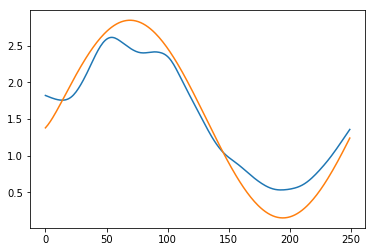

In [72]:
plt.plot(trend)
plt.plot(m1)
plt.show()

In [75]:
mid = numDer(trend)
alphae2 = alpha(trend, mid)
print(alphae2)

89.14902535462055
